## SRCNN의 목표
> 사진의 특정부분을 확대(upscaling) -> bicubic interpolation  

> **bicubic interpolation으로 흐려진 화질을 원본에 가깝게 복원한다.**

In [1]:
import torch
from torch import nn
# import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import ToTensor, ToPILImage
# from torchvision.datasets.imagenet import ImageNet
from PIL import Image
# from PIL import ImageFilter
import glob
import numpy as np
import matplotlib.pyplot as plt

## Data preprocessing

In [2]:
# using PIL
class SRdataset(Dataset):
    def __init__(self, data_path, size_gap, sub_img_size = 33, stride = 14, upscale_factor = 3):
        super(Dataset, self).__init__()
        self.data_path = glob.glob(data_path)

        # data color channel 확인
        tmp = Image.open(self.data_path[0])
        print(f"Dataset's color mode is:{tmp.getbands()}, example size is:{tmp.size}")

        # 고해상 이미지는 filter size로 인해 크기가 작아진다.
        # 줄어드는 사이즈에 맞는 label 생성을 위한 멤버변수 -> size gap
        # 실험적으로 제시된 stride = 14, upscale factor = 3
        self.sub_img_size = sub_img_size
        self.size_gap = size_gap    
        self.stride = stride
        self.upscale_factor = upscale_factor
        self.data, self.label = [] , []
        self.transform = ToTensor()
        
        # start preprocessing
        # cropping imgs
        for path in self.data_path:
            img = Image.open(path)
            self.cropping(img, self.sub_img_size, self.size_gap, self.stride)
        
        # cropping 확인
        plt.subplot(1,3,1)
        plt.imshow(self.data[0])
        plt.title("cropped data")
        plt.subplot(1,3,2)
        plt.imshow(self.label[0])
        plt.title("cropped label")
        print(f"cropped img type: {type(self.data[0])}, width: {self.data[0].width}, height: {self.data[0].height}")

        # apply bicubic interpolation
        for idx in range(len(self.data)):
            self.data[idx] = self.bicubic_interpolation(self.data[idx],self.upscale_factor)

        plt.subplot(1,3,3)
        plt.imshow(self.data[0])
        plt.title("bicubic-I data")

        # label 정규화
        for idx in range(len(self.label)):
            self.label[idx] = np.asarray(self.label[idx], dtype=np.float32)/255.0
        
        # data transforming to Tensor
        for idx in range(len(self.data)):
            self.data[idx],self.label[idx] = self.transform(self.data[idx]), self.transform(self.label[idx])
        print(f"Now datatype is:{type(self.data[0])}")
        
    # stride를 14로 돌면서 img를 sub_img_size만큼 crop하여 train data 생성, size 변화 고려하여 data에 맞는 label 생성
    def cropping(self, img, sub_img_size, size_gap, stride):
        for i in range(0, img.height - sub_img_size + 1, stride):
            for j in range(0, img.width - sub_img_size + 1, stride):
                # sample crop으로 train sub image 생성
                cropped_temp = img.crop((j, i, j+sub_img_size, i+sub_img_size))
                self.data.append(cropped_temp)
                # size 축소에 따른 label 저장
                label_temp = img.crop((j+size_gap, i+size_gap, j+sub_img_size-size_gap,\
                                       i+sub_img_size-size_gap))
                self.label.append(label_temp)

    # upscale factor는 3으로, 먼저 upscale factor로 sub-sample해준다.(1/3으로 축소), 이후 다시 upscale factor만큼 확대해준다. 흐릿해지는 효과
    def bicubic_interpolation(self, data, scale):
        w,h = data.size
        tempw, temph = w//scale, h//scale
        temp = data.resize((tempw,temph), Image.BICUBIC)
        return temp.resize((w,h),Image.BICUBIC)
        # F.interpolate(data, scale_factor= (1/scale), mode = 'bicubic')
        # F.interpolate(data, scale_factor= scale, mode = 'bicubic')  
        # return 
    
    # data 길이 반환함수
    def __len__(self):
        return len(self.data)
    
    # indexing을 위한 overiding
    def __getitem__(self,idx):
        x,y = self.data[idx],self.label[idx]
        return x,y
    

## Define dataset & dataloader 

Dataset's color mode is:('R', 'G', 'B'), example size is:(197, 176)
cropped img type: <class 'PIL.Image.Image'>, width: 33, height: 33
Now datatype is:<class 'torch.Tensor'>

Dataset's color mode is:('R', 'G', 'B'), example size is:(197, 176)
cropped img type: <class 'PIL.Image.Image'>, width: 33, height: 33
Now datatype is:<class 'torch.Tensor'>

train_dataset 0's type:<class 'torch.Tensor'>, shape:torch.Size([3, 33, 33])
train_loader.dataset:22092
train_loader_length:173
type of train data:<class 'torch.Tensor'>, type of train label:<class 'torch.Tensor'>, shape of d:torch.Size([128, 3, 33, 33]), shape of lab:torch.Size([128, 3, 17, 17])


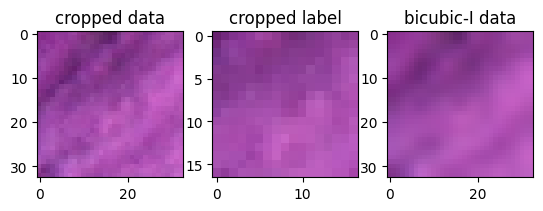

In [3]:
# params for dataset
data_path, test_path1, test_path2 = "./T91/*.png", "./Set5/Set5/*.png", "./Set14/Set14/*.png"
sub_img_size, stride, upscale_factor = 33, 14, 3
# data - label gap 계산
f1, f2, f3 = 9, 5, 5
out_img_size = sub_img_size - (f1+f2+f3) + 3
size_gap = (sub_img_size - out_img_size)//2

#params for dataloader
batch_size = 128
train_dataset = SRdataset(data_path, size_gap, sub_img_size , stride, upscale_factor)
# test_dataset1 = SRdataset(test_path1, sub_img_size, size_gap, stride, upscale_factor)
print()
test_dataset2 = SRdataset(data_path, size_gap, sub_img_size , stride, upscale_factor)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
test_loader2 = DataLoader(test_dataset2, batch_size = batch_size)


print(f"\ntrain_dataset 0's type:{type(train_dataset[0][0])}, shape:{train_dataset[0][0].shape}")
print(f"train_loader.dataset:{len(train_loader.dataset)}")
print(f"train_loader_length:{len(train_loader)}")
# train_loader test
for data, label in train_loader:
    img, lab = data[0], label[0]
    print(f"type of train data:{type(data)}, type of train label:{type(label)}, shape of d:{data.shape}, shape of lab:{label.shape}")
    break


## Model

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device is {device}")

device is cuda


In [5]:
class SRCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3,out_channels=128,kernel_size=9)
        self.conv2 = nn.Conv2d(128,64,kernel_size=5)
        self.conv3 = nn.Conv2d(64,3,kernel_size=5)
        self.relu = nn.ReLU()
        # 가중치 초기화
        nn.init.normal_(self.conv1.weight, mean=0, std=0.001)
        nn.init.normal_(self.conv2.weight, mean=0, std=0.001)
        nn.init.normal_(self.conv3.weight, mean=0, std=0.001)
        nn.init.zeros_(self.conv1.bias)
        nn.init.zeros_(self.conv2.bias)
        nn.init.zeros_(self.conv3.bias)
        
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)

        return x



## Train & Eval

**모델 파라미터와 bias 초기화, lr 변화, optimizer종류,psnr함수 적용**

In [6]:
import tqdm

# Super Resolution 평가 함수, mse가 작을 수록 좋은 지표 (psnr값이 클수록)
def psnr(pred, label):
    # 픽셀 최대값으로 정규화, 최대값의 제곱은 1.0
    #pTmp = pred / 255.0; #lTmp = label / 255.0
    # MSE(Mean Squared Error) 계산
    mse = torch.mean((pred - label) ** 2)  
    # log10(1**2/mse) -> log10(1/sqrt(mse))
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def train(train_loader , model , lossF , optimizer):
    # dataSize = len(train_loader.dataset)
    runningLoss = 0.
    runningPsnr = 0.
    for (data, label) in tqdm.tqdm(train_loader):
        data,label = data.to(device),label.to(device)
        optimizer.zero_grad()
        pred = model(data)
        loss = lossF(pred,label)
        
        runningLoss += loss.item()
        runningPsnr += psnr(pred,label)

        loss.backward()
        optimizer.step()
    epochLoss, psnrV = runningLoss/len(train_loader), runningPsnr/len(train_loader)
    return epochLoss, psnrV

def test(test_loader, model, lossF):
    totalLoss = 0.
    finalPsnr = 0.
    with torch.no_grad():
        for data, label in tqdm.tqdm(test_loader):
            data , label = data.to(device), label.to(device)
            pred = model(data)
            totalLoss += lossF(pred,label).item()
            finalPsnr += psnr(pred,label)
    print(f"\ntest loss:{totalLoss / len(test_loader) * 100}, test psnr: {finalPsnr / len(test_loader)}")

In [7]:
epoch = 300
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = SRCNN().to(device)
# # 레이어별 다른 lr설정을 위한 네트워크 파라이터 cutomize
c_parameters, c_lr = [] , {'conv3.weight':1e-5}

for name, param in model.named_parameters():
    if name in c_lr: c_parameters.append({'params':param, 'lr':c_lr[name]})
    else: c_parameters.append({'params':param})

lossF = nn.MSELoss()
# basic lr -> 0.0001
optimizer = optim.Adam(c_parameters , lr = 1e-4)
# optimizer = optim.Adam(model.parameters(), lr = 1e-4)  

print(model)
for epochNum in range(1,epoch + 1):
    if epochNum%50 == 0:
        epochLoss, psnrV = train(train_loader,model,lossF,optimizer)
        print(f"Train epoch:{epochNum}----loss:{epochLoss}----psnr value:{psnrV}-----")
    else: train(train_loader,model,lossF,optimizer)

print("Train end")



cuda
SRCNN(
  (conv1): Conv2d(3, 128, kernel_size=(9, 9), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
)


100%|██████████| 173/173 [00:03<00:00, 43.37it/s]


Train epoch:50----loss:0.0024200567529493715----psnr value:27.785932540893555-----


100%|██████████| 173/173 [00:04<00:00, 42.37it/s]


Train epoch:100----loss:0.0022949696425281227----psnr value:27.92978286743164-----


100%|██████████| 173/173 [00:04<00:00, 42.73it/s]


Train epoch:150----loss:0.0019862517114591412----psnr value:28.873777389526367-----


100%|██████████| 173/173 [00:04<00:00, 42.97it/s]


Train epoch:200----loss:0.0019145477569871986----psnr value:29.062854766845703-----


100%|██████████| 173/173 [00:04<00:00, 42.17it/s]


Train epoch:250----loss:0.0018685508842917827----psnr value:29.185388565063477-----


100%|██████████| 173/173 [00:04<00:00, 42.88it/s]

Train epoch:300----loss:0.0018328637226364935----psnr value:29.273408889770508-----
Train end


100%|██████████| 173/173 [00:01<00:00, 113.89it/s]



test loss:0.18390834788593996, test psnr: 29.259578704833984
test end, visual test start
picture shape:(150, 200)
torch.Size([1, 3, 600, 450])
SR img shape:(434, 584)


Text(0.5, 1.0, 'Cropped Resolution')

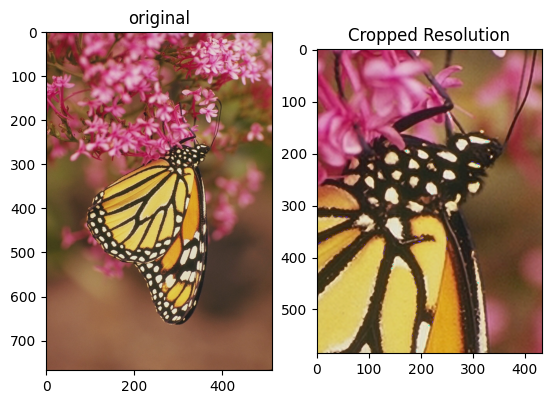

In [13]:
batch_size,lr12,lr3,kernelSize,channelSize,epoch = 128,4,5,'955','128_64',300
fname = 'monarch'

model.eval()
with torch.no_grad():
    test(test_loader2 , model , lossF)

print("test end, visual test start")

transform = ToTensor(); imgName = fname + '.png'
vtImage = Image.open('./Set14/Set14/'+imgName)
plt.subplot(1,2,1)
plt.imshow(vtImage)
plt.title('original')
# 확대된 이미지 (원본)
# vtImage = vtImage.resize((w*3,t*3),Image.BICUBIC)
vtImage = vtImage.crop((250,200,400,400))
print(f"picture shape:{vtImage.size}")
# vtDir = f'batch{batch_size}_lr_{lr12}_{lr3}_ker{kernelSize}_cha{channelSize}_epoch{epoch}/'
# vtFile = f'{fname}_resized1.png'
# vtImage.save('./testMonarch/' + vtDir + vtFile)

w,t = vtImage.size
vtImage = vtImage.resize((w*3,t*3),Image.BICUBIC)
w,t = vtImage.size
size_gap = (sum([int(ch) for ch in kernelSize]) - 3) // 2
vtTemp = vtImage.crop((size_gap , size_gap , w - size_gap , t - size_gap))
vtDir = f'batch{batch_size}_lr_{lr12}_{lr3}_ker{kernelSize}_cha{channelSize}_epoch{epoch}/'
vtFile = f'upscaled{fname}1.png'
vtTemp.save('./testMonarch/' + vtDir + vtFile)

vtTensor = transform(vtImage).unsqueeze(0)
print(vtTensor.shape)

model.eval()
with torch.no_grad():
    vtTensor = vtTensor.to(device)
    output = model(vtTensor)
vtOutput = ToPILImage()(output.squeeze(0))
 
print(f"SR img shape:{vtOutput.size}")

vtDir = f'batch{batch_size}_lr_{lr12}_{lr3}_ker{kernelSize}_cha{channelSize}_epoch{epoch}/'
vtFile = f'{fname}1.png'
vtOutput.save('./testMonarch/' + vtDir + vtFile)

plt.subplot(1,2,2)
plt.imshow(vtOutput)
plt.title("Cropped Resolution")


## Model & parameters save and Load

In [14]:
torch.save(model.state_dict(),f"SRCNN_{epoch}.pth")
print(f"model saved succedssfully")

model saved succedssfully


In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SRCNN().to(device)
epoch = 300
model.load_state_dict(torch.load(f"SRCNN_{epoch}.pth"))
print(f"model successfully loaded")

model successfully loaded


## Inference by real world data

In [27]:
# 다음 코드로 이미지 확장자를 확인할 수 있다. img.format
# with Image.open(image_path) as img:
#             # Check the format of the image
#             print(f"The format of the image is: {img.format}")
batch_size,lr12,lr3,kernelSize,channelSize,epoch = 128,4,5,'955','128_64',300
fname = 'infer3'
dataPath = './inferenceData/' + fname + '.JPG'
jpgimg = Image.open(dataPath)
pngPath = dataPath.replace('.JPG','.PNG')
jpgimg.save(pngPath)
jpgimg.close()
### 1. 사용자가 이미지 업로드
### 2. 이미지에서 자를부분 선택
### 3. 선택된 이미지를 bicubic (original)
### 4. bicubic 이미지를 sr로 (SR)


picture shape:(960, 1280)
result size:(2084, 2384)


Text(0.5, 1.0, 'Super Resolution')

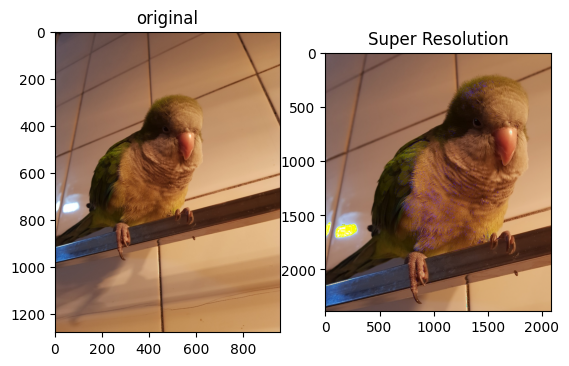

In [30]:
dataPath = pngPath
imgOri = Image.open(dataPath)
imgOri = imgOri.convert('RGB')


# imgOri = imgOri.resize((w*3,t*3), Image.BICUBIC)
# imgOri.save(f'./inferenceData/batch{batch_size}_lr_{lr12}_{lr3}_ker{kernelSize}_cha{channelSize}_epoch{epoch}/{fname}_resized1.png')
plt.subplot(1,2,1)
plt.imshow(imgOri)
plt.title('original')
print(f"picture shape:{imgOri.size}")
# 확대할 이미지 선택
imgOri = imgOri.crop((0,200,700,1000))
w,t = imgOri.size
# 확대(upscale) 비율 -> 3
imgOri = imgOri.resize((w*3,t*3),Image.BICUBIC)

w,t = imgOri.size
size_gap = (sum([int(ch) for ch in kernelSize]) - 3) // 2
imgTemp = imgOri.crop((size_gap , size_gap , w - size_gap , t - size_gap))
imgTemp.save(f'./inferenceData/batch{batch_size}_lr_{lr12}_{lr3}_ker{kernelSize}_cha{channelSize}_epoch{epoch}/{fname}_bicubic.png')

transform = ToTensor()
img = transform(imgOri).unsqueeze(0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
img = img.to(device)

model.eval()
with torch.no_grad():
    output = model(img)
infed = ToPILImage()(output.squeeze(0))

print(f"result size:{infed.size}")

infed.save(f'./inferenceData/batch{batch_size}_lr_{lr12}_{lr3}_ker{kernelSize}_cha{channelSize}_epoch{epoch}/{fname}_final1.png')

plt.subplot(1,2,2)
plt.imshow(infed)
plt.title('Super Resolution')